# Advanced DL and RL: Домашнее задание 1

Студент: Самохвалов Михаил

Группа: MADE-DS-32

Email: sam2051@yandex.ru

Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое, чтобы можно было обучить хорошую стратегию методами TD-обучения или другими методами обучения с подкреплением. Задание получилось, надеюсь, интересное, но в том числе и достаточно техническое, так что для решения придётся немножко попрограммировать. Поэтому в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.


## Часть первая, с блекджеком и стратегиями

Мы будем обучаться играть в очень простую, но всё-таки знаменитую и популярную игру: блекджек. Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
 - численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
 - туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
 - игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
 - игрок может совершать одно из двух действий:
    - hit  — взять ещё одну карту;
    - stand — не брать больше карт;
 - если сумма очков у игрока на руках больше 21, он проигрывает (bust);
 - если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
 - после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
 - в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).
 
Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/38a1f630dc9815a567aaf299ae5844c8f8b9a6fa/gym/envs/toy_text/blackjack.py

In [4]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.notebook import tqdm

from gym.envs.toy_text.blackjack import BlackjackEnv

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [141]:
env = gym.make('Blackjack-v0', natural=True)
observation = env.reset()
env.seed(42)
# The observation of a 3-tuple of: the players current sum,
#     the dealer's one showing card (1-10 where 1 is ace),
#     and whether or not the player holds a usable ace (0 or 1) - i.e. use Ace as 11.

observation, reward, done, info = env.step(0)

In [143]:
def play_round(strategy):
    obs = env.reset()
    done = False
    while not done:
        action = strategy(obs)
        obs, reward, done, info = env.step(action)
    return reward


### 1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [144]:
# hit = 1
# stand = 0

def trivial_strategy(observation):
    if observation[0] > 18:
        return 0
    else:
        return 1

In [152]:
n_iter = 100_000
mean_reward = 0

for i in tqdm(range(1, n_iter+1)):
    reward = play_round(trivial_strategy)
    mean_reward += reward / n_iter
#     mean_reward += (reward - mean_reward) / i
env.close()

In [153]:
print(f'Средняя награда при {n_iter} сыгранных играх {mean_reward:.3f}')
print(f'Средняя награда при {n_iter} сыгранных играх без natural 0.20')

Средняя награда при 100000 сыгранных играх -0.179
Средняя награда при 100000 сыгранных играх без natural 0.20


### 2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [167]:
class QLearning():
    
    def __init__(self, env, lr, dr, eps, seed=0, plot_step=500):
        self.env = env
        self.lr = lr # learning rate
        self.dr = dr # discount rate
        self.eps = eps
        
        self.plot_step = plot_step
        
#         self.env = gym.make('Blackjack-v0', natural=True)
        self.env.seed(seed)
        np.random.seed(seed)
        self.Q = defaultdict(lambda: [0.0]*self.env.action_space.n) # or we can random init here!
    
    def get_action(self, state, train=False):
        r = np.random.rand()
#         print('    r=', r)
        if r < self.eps and train:
#             print('FIRST')
            action = np.random.choice(self.env.action_space.n)
        else:
#             print('SECOND')
            action = np.argmax(self.Q[state])
        return action
    
    def update_Q(self, new_state, state, action, reward):
        tmp = self.Q[state][action] + \
                 self.lr * (reward + self.dr * np.max(self.Q[new_state]) - self.Q[state][action])
        self.Q[state][action] = tmp
    
    def play_game(self, train=True):
        state = self.env.reset()
        done = False
        while not done:
            action = self.get_action(state, train)
            new_state, reward, done, _ = self.env.step(action)
#             print('  action', action)
#             print('  state', state)
#             print('  new_state', new_state)
#             print('  reward', reward)
            if train:
                self.update_Q(new_state, state, action, reward)
            state = new_state
        return reward
    
    def run(self, n_iter, train=True, plot=False):
        mean_reward = 0
        plot_rewards = []
        timesteps = []
        for i in tqdm(range(n_iter)):
#             print('='*30)
#             print(i+1)
            reward = self.play_game(train=train)
#             print('reward', reward)
            
            mean_reward += (reward - mean_reward) / (i + 1)
            if plot and i>1 and i % self.plot_step == 0:
                plot_rewards.append(mean_reward)
                timesteps.append(i)
            
        # render
        if plot:
            plt.figure(figsize=(16, 9))
            plt.plot(timesteps, plot_rewards)
            plt.xlabel('Games played')
            plt.ylabel('Mean Reward')
            plt.title('Total result:')
            plt.grid()
            plt.show()

        return mean_reward
    
    def finish(self):
        self.env.close()
        



TEST



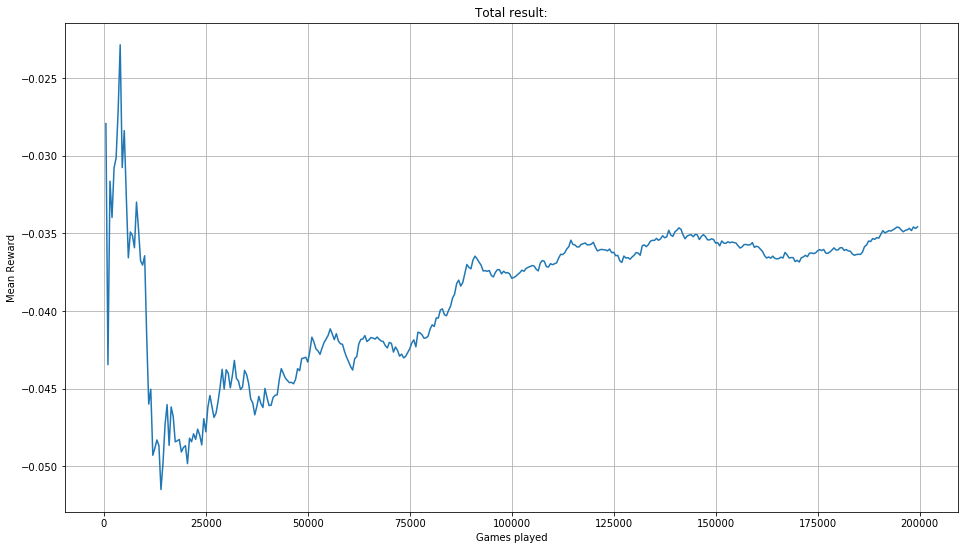

Final test mean reward -0.03454000000000048


In [65]:
N = 200_000
env = gym.make('Blackjack-v0', natural=True)
model = QLearning(env, 0.000001, 1, 0.7, seed=0)
model.run(N, train=True)
print('\nTEST\n')
test_mean_reward = model.run(N, train=False, plot=True)
model.finish()

print('Final test mean reward', test_mean_reward)

In [ ]:
# GreedSearch
N = 50_000

best_params = 0

for a in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]:
    for eps in [0, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0]:
        print('a=', a, 'eps=', eps)
        model = QLearning(a, 1, eps)
        model.run(N, train=True)
        r = model.run(N, train=False, plot=True)
        if r > best_r:
            best_r = r
            best_params = (a,eps)
        model.finish()

# Result:
# best_params = (1e-06, 0.7)
# best_r = -0.03301999999999999

Лучшие результаты получаются, если не обучать модель слишком долго (переобучение??)
Есть идея генерировать случайно веса в начале, но не попробовал.

## Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:

**double** — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

### 4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [66]:
class BlackJackDouble(BlackjackEnv):
    
    def __init__(self, natural=True, seed=0):
        super().__init__(natural)
        self.seed(seed)
        np.random.seed(seed)
        self.action_space.n = 3
        
    def step(self, action):
        if action == 2:
            obs, reward, done, info = super().step(1)
            if not done:
                obs, reward, done, info = super().step(0)
            return obs, reward * 2, done, info
        else:
            return super().step(action)
        

### 5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.



TEST



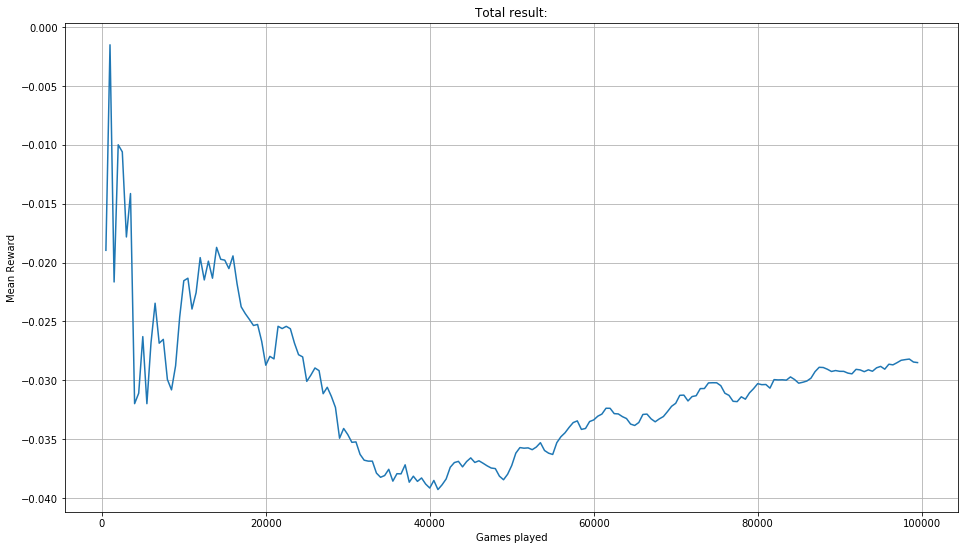

Best mean reward for Double BlackJack for 100000 iterations: -0.02840


In [88]:
N = 100_000
env = BlackJackDouble(natural=True, seed=0)
model = QLearning(env, 0.0008, 0.9, 0.7, seed=0, plot_step=500)
model.run(N, train=True)
print('\nTEST\n')
double_best_result = model.run(N, train=False, plot=True)
model.finish()

print(f"Best mean reward for Double BlackJack for {N} iterations: {double_best_result:.5f}")

Удваивая ставку можно получить результат лучше, чем в классической игре. Но мы все же проигрываем

## Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

### 6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).


In [120]:
from gym import spaces
from gym.utils import seeding
from gym.envs.toy_text.blackjack import cmp, usable_ace, sum_hand, is_bust, score, is_natural

class BlackJackHoffman(BlackjackEnv):
    
    def __init__(self, natural=True, seed=0, min_number=15):
        self.action_space = gym.spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        
        self.natural = natural
        self.seed(seed)
        self.min_number = min_number
        
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
        self.counter = 0
        
        self.seed(seed)
        np.random.seed(seed)
        self.reset()
        
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
        
    def weight(self, card):
        if card in [3,4,6]:
            return 1
        elif card in [2,7]:
            return 0.5
        elif card in [1,10]:
            return -1
        elif card == 5:
            return 1.5
        elif card == 8:
            return 0
        else:
            return -0.5
        
    def draw_card(self, np_random):
        position = np_random.randint(0, len(self.deck))
        return self.deck.pop(position)
    
    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]
    
    def get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.counter)
    
    def step(self, action):
        if action == 2:
            obs, reward, done, info = super().step(1)
            if not done:
                obs, reward, done, info = super().step(0)
            return obs, reward * 2, done, info
        else:
            return super().step(action)
        
    def step(self, action):
        assert self.action_space.contains(action)
        if action == 2:
            obs, reward, done, _ = self.step(1)
            if not done:
                obs, reward, done, _ = self.step(0)
            reward = reward * 2
        elif action:  # hit: add a card to players hand and return
            current_card = self.draw_card(self.np_random)
            self.player.append(current_card)
            self.counter += self.weight(current_card)
            if is_bust(self.player):
                done = True
                reward = -1.
#                 self.counter += self.weight(self.dealer[1]) # ?????
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            
            for card in self.dealer[1:]:
                self.counter += self.weight(card)
            
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def reset(self):
        if (len(self.deck) < self.min_number):
            self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
            self.counter = 0
        self.dealer = self.draw_hand(self.np_random)
        self.player = self.draw_hand(self.np_random)
#         print(self.dealer)
#         print(self.player)
        self.counter += self.weight(self.dealer[0]) # shows first card only at start!
        self.counter += self.weight(self.player[0])
        self.counter += self.weight(self.player[1])
        return self.get_obs()
        



TEST



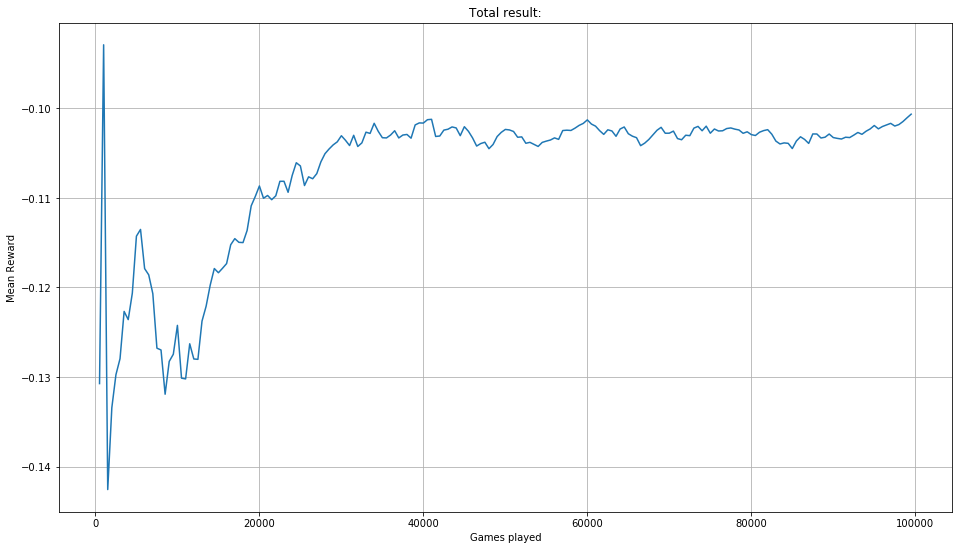

Best mean reward for Double BlackJack for 100000 iterations: -0.10079


In [180]:
N = 100_000

seed = 3

env = BlackJackHoffman(natural=True, seed=seed)
model = QLearning(env, 0.0008, 0.9, 0.7, seed=seed, plot_step=500)
model.run(N, train=True)
print('\nTEST\n')
double_best_result = model.run(N, train=False, plot=True)
model.finish()

print(f"Best mean reward for Double BlackJack for {N} iterations: {double_best_result:.5f}")

Модель с запоминанием карт сошла с ума и только ухудшила результаты, что странно...

In [ ]:
# # GreedSearch
# N = 50_000

# best_params = 0
# best_r = -100

# for gamma in [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
#     for a in [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]:
#         for eps in [0, 0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1.0]:
#             print('a=', a, 'eps=', eps)
#             env = BlackJackHoffman(natural=True, seed=0)
#             model = QLearning(env, a, gamma, eps, seed=0, plot_step=500)
#             model.run(N, train=True)
#             r = model.run(N, train=False, plot=True)
#             if r > best_r:
#                 best_r = r
#                 best_params = (a,eps)
#             model.finish()